## Script to group the WaPR water use data into a single netCDF file

In [1]:
from netCDF4 import Dataset
import rasterio as rs
from affine import Affine
from pyproj import Proj, transform

In [2]:
# create x and y grids for the cell centers

with rs.open('../UOG/data/haines_tiffs/treatment_water_2008_Float64.tiff') as ds:
    T0 = ds.affine # upper left pixel corner affine transform
    A = ds.read(1) # get pixel values
    cs = T0[0] # get cell size
    
# generate rows and columns
cols,rows = np.meshgrid(np.arange(A.shape[1]), np.arange(A.shape[0]))

In [3]:
ds.crs['units'] = 'us-ft' # correct the units from the tif image
ds.crs['to_meter'] = 0.304800609601219 # add the to meters correction

In [4]:
p1 = Proj(ds.crs, preserve_units=True) # generate the proj4 instance for the dataset's native projection

In [5]:
T1 = T0 * Affine.translation(0.5,0.5) # get affine transform for pixel centers
rc2en = lambda r,c: (c,r) * T1 # function to convert row/col index to easting/northing at centre
eastings,northings  = np.vectorize(rc2en)(rows,cols) # create grids of cell centers

In [6]:
m,n = eastings.shape # y,x format
x = np.reshape(eastings,(m*n))
y = np.reshape(northings,(m*n))

448 466


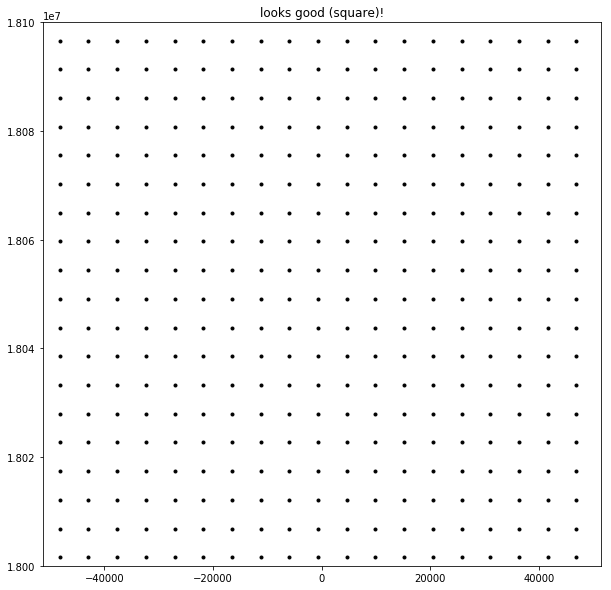

In [7]:
# check that the data are square
print(m,n)
plt.figure(figsize=(10,10));
plt.plot(x,y,'.k');
plt.axis('equal');
plt.ylim(1.8e7,1.81e7);
plt.xlim(-25000,25000);
plt.title('looks good (square)!');

## check the min/max of the projected coodinates agains gdalinfo and account for the cell size

$ gdalinfo treatment_water_1980.tif

Upper Left  (-1127952.760,19530138.164) (108d48' 7.59"W, 50d51'23.37"N)

Lower Left  (-1127952.760,17164698.164) (108d19'24.23"W, 44d25'25.98"N)

Upper Right ( 1332527.240,19530138.164) ( 98d19'44.51"W, 50d49'29.11"N)

Lower Right ( 1332527.240,17164698.164) ( 98d53'38.40"W, 44d23'41.11"N)

Center      (  102287.240,18347418.164) (103d35'13.30"W, 47d43'55.74"N)

In [8]:
! gdalinfo ../UOG/data/haines_tiffs/treatment_water_1980_Float64.tiff

Driver: GTiff/GeoTIFF
Files: ../UOG/data/haines_tiffs/treatment_water_1980_Float64.tiff
Size is 466, 448
Coordinate System is:
PROJCS["LTUC_lambert_conformal_conic_ft",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.2572221010042,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Lambert_Conformal_Conic_2SP"],
    PARAMETER["standard_parallel_1",33],
    PARAMETER["standard_parallel_2",45],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-104],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["US survey foot",0.3048006096012192,
        AUTHORITY["EPSG","9003"]]]
Origin = (-1127952.760083764791489,19530138.164061054587364)
Pixel Size = (5280.000000000000000,-5280.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Stru

In [9]:
print('Upper Left: (%s,%s)'%(round(x.min()-(cs/2),3),round(y.max()+(cs/2),3)))
print('Lower Right: (%s,%s)'%(round(x.max()+(cs/2),3),round(y.min()-(cs/2),3)))

Upper Left: (-1127952.76,19530138.164)
Lower Right: (1332527.24,17164698.164)


## Looks good!

## Create the variables for the dataset

In [10]:
out.close()

NameError: name 'out' is not defined

In [11]:
data = Dataset('../UOG/data/haines_tiffs/test.nc')

In [12]:
data.variables

OrderedDict([('lambert_conformal_conic', <class 'netCDF4._netCDF4.Variable'>
              |S1 lambert_conformal_conic()
                  grid_mapping_name: lambert_conformal_conic
                  longitude_of_central_meridian: -104.0
                  false_easting: 0.0
                  false_northing: 0.0
                  latitude_of_projection_origin: 0.0
                  standard_parallel: [ 33.  45.]
                  longitude_of_prime_meridian: 0.0
                  semi_major_axis: 6378137.0
                  inverse_flattening: 298.257222101
                  spatial_ref: PROJCS["LTUC_lambert_conformal_conic_ft",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010002,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["latitude_of

In [13]:
out = Dataset('./data/wapr_treatment_water.nc','w',format='NETCDF4')

In [14]:
# create the dimensions of the dataset
out.createDimension('x',n)
out.createDimension('y',m)
out.createDimension('time',None)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0

In [15]:
Easting = out.createVariable('Easting','f4',('x','y'))
Northing = out.createVariable('Northing','f4',('x','y'))
Time = out.createVariable('Time','i4','time')
TreatmentWater = out.createVariable('TreatmentWater',np.float64,('time','x','y'),fill_value=-9999)

In [16]:
# fill the netcdf file with spatial data
Easting[:] = x
Northing[:] = y

In [17]:
# create year and band variables
years = []
bands = []
year = 1980
for band in np.arange(1,38):
    years.append(year)
    bands.append('Band%s'%band)
    year += 1
    
df = pd.DataFrame({'year':years,'band':bands})

In [18]:
df = df[(df.year>=2000) & (df.year <=2015)]

In [41]:
ct = 0
for year,band in zip(df.year,df.band):
    Time[ct] = year
    rast = np.array(data.variables[band])
    TreatmentWater[ct,:,:] = rast
    ct += 1

In [20]:
np.array(data.variables['Band14']).dtype

dtype('float64')

In [21]:
out.variables['TreatmentWater']

<class 'netCDF4._netCDF4.Variable'>
float64 TreatmentWater(time, x, y)
    _FillValue: -9999.0
unlimited dimensions: time
current shape = (16, 466, 448)
filling on

In [43]:
ct

16

In [44]:
rast = np.array(out.variables['TreatmentWater'][15,:,:])

In [45]:
rast.dtype

dtype('float64')

(0.0, 448.0, 0.0, 466.0)

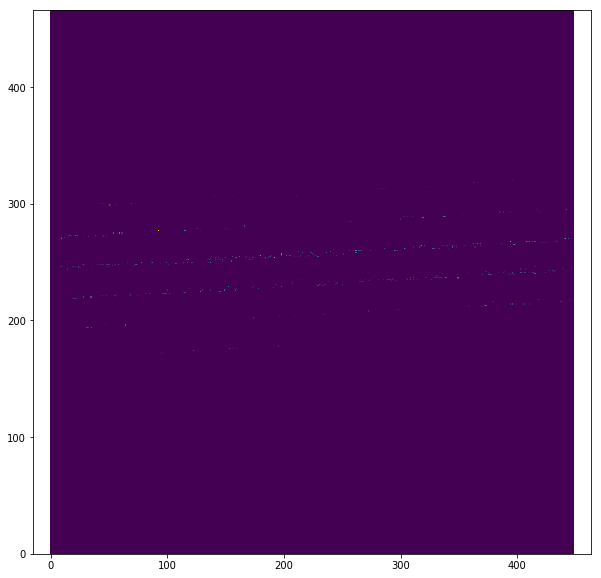

In [46]:
plt.figure(figsize=(10,10))
plt.pcolormesh(rast)
plt.axis('equal')

In [15]:
files = glob.glob('../UOG/data/haines_tiffs/treatment_water_*_Float64.tiff')

In [16]:
dat = pd.DataFrame({'file':files})

In [28]:
def get_year(fl): return int(fl.split('/')[-1].split('_')[-2])

In [23]:
fl = files[0]
fl.split('/')[-1].split('_')[-2]

'1980'

In [29]:
dat['year'] = dat.file.map(get_year)

In [30]:
dat.sort_values(by='year',ascending=True, inplace=True) # sort by year

In [31]:
dat = dat.loc[(dat.year>=2006) & (dat.year <= 2015)]

In [32]:
import gdal

In [44]:
# fill the treatmentwater and time variables
ct = 0
for year,fl in zip(dat.year.as_matrix(),dat.file.as_matrix()):
    Time[ct] = year
    print(fl)
    ds = gdal.Open(fl,gdal.GA_ReadOnly)
    tmp = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=np.float64)
    nd = ds.GetRasterBand(1).GetNoDataValue()
    rast = tmp.copy()
    #rast[rast==nd] = np.NaN
    #rast[rast > 2.0e9] = -9999
    #rast[rast < 0] = -9999
    #rast[np.isinf(rast)] = -9999
    print('Number: %s -- min: %s, max: %s, nodata: %s'%(ct,np.nanmin(rast),np.nanmax(rast),nd))
    #rast[np.isnan(rast)] = -9999
    
    TreatmentWater[ct,:,:] = rast
    ct += 1
    
    #ds = rs.open(fl)
    #print(fl)
    #vals = np.array(ds.read(1),dtype=np.float64)    
    #vals[vals==2147483647] = np.NaN
    #vals[vals==4.29495731e+09] = np.NaN
    #vals[vals==2.14748365e+09] = np.NaN
    #vals[np.isinf(vals)] = np.NaN
    #print(np.nansum(vals))
    #vals[np.isnan(vals)] = -9999
    #vals[vals<0] = -9999
    
    
    

../UOG/data/haines_tiffs/treatment_water_2006_Float64.tiff
Number: 0 -- min: -9999.0, max: 2457588.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2007_Float64.tiff
Number: 1 -- min: -9999.0, max: 5958540.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2008_Float64.tiff
Number: 2 -- min: -9999.0, max: 3286424.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2009_Float64.tiff
Number: 3 -- min: -9999.0, max: 8206548.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2010_Float64.tiff
Number: 4 -- min: -9999.0, max: 10864728.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2011_Float64.tiff
Number: 5 -- min: -9999.0, max: 12749100.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2012_Float64.tiff
Number: 6 -- min: -9999.0, max: 24524430.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2013_Float64.tiff
Number: 7 -- min: -9999.0, max: 43248072.0, nodata: -9999.0
../UOG/data/haines_tiffs/treatment_water_2014_Float6

In [45]:
np.array(out.variables['Time'])

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int32)

In [46]:
out.variables['TreatmentWater']

<class 'netCDF4._netCDF4.Variable'>
float64 TreatmentWater(time, x, y)
    _FillValue: -9999.0
unlimited dimensions: time
current shape = (10, 466, 448)
filling on

In [47]:
np.array(out.variables['TreatmentWater'][1,:,:])

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ..., 
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [48]:
out.variables['TreatmentWater'][9,:,:]

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = -9999.0)

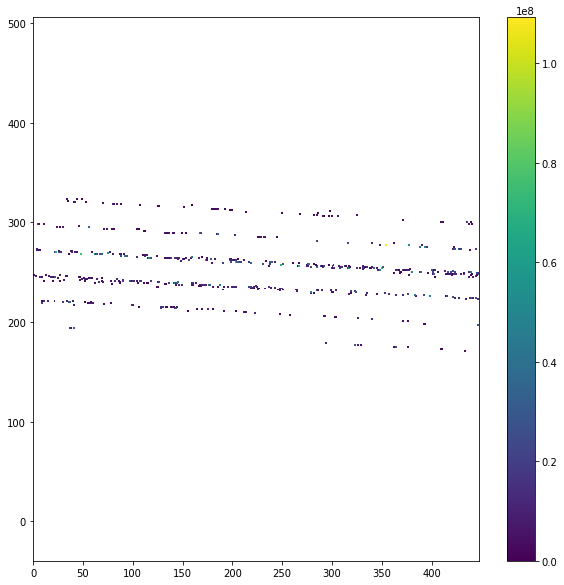

In [51]:
plt.figure(figsize=(10,10))
rast = out.variables['TreatmentWater'][9,:,:]
plt.pcolormesh(np.flipud(rast),vmin=0,vmax=np.nanmax(rast))
plt.axis('equal')
plt.colorbar()

(0.0, 448.0, 0.0, 466.0)

/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


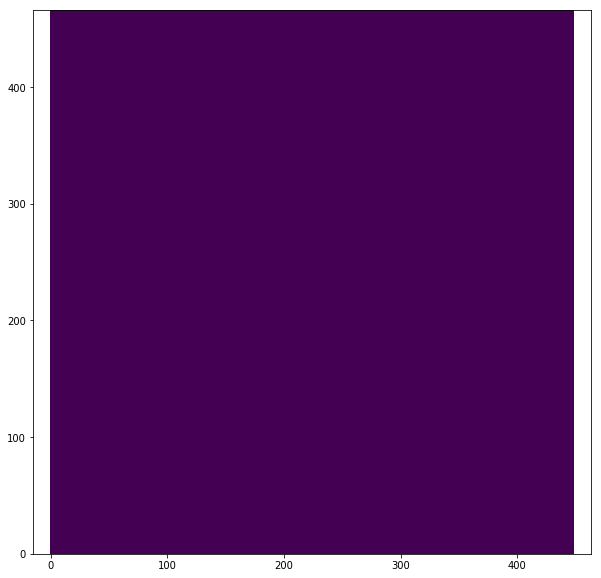

In [43]:
ma = np.ma.masked_array(rast,rast==-9999)
plt.figure(figsize=(10,10))
plt.pcolormesh(np.flipud(ma))
plt.axis('equal')

(0.0, 448.0, 0.0, 466.0)

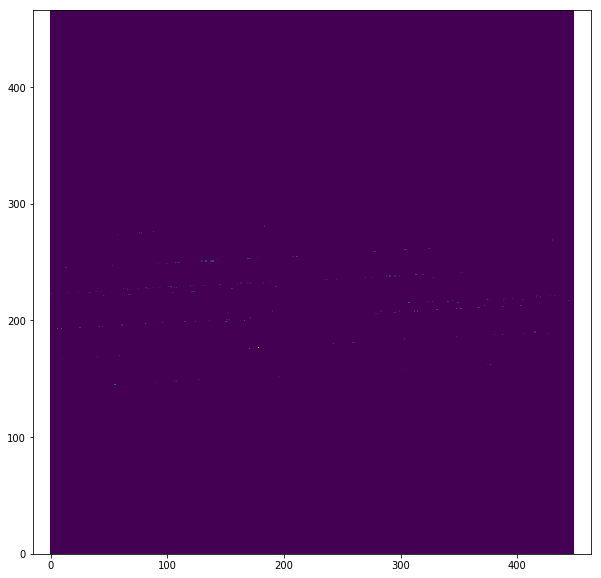

In [174]:
plt.figure(figsize=(10,10))
plt.pcolormesh(np.array(out.variables['TreatmentWater'][1,:,:]))
plt.axis('equal')

In [175]:
fl

'../UOG/data/haines_tiffs/treatment_water_2015.tif'

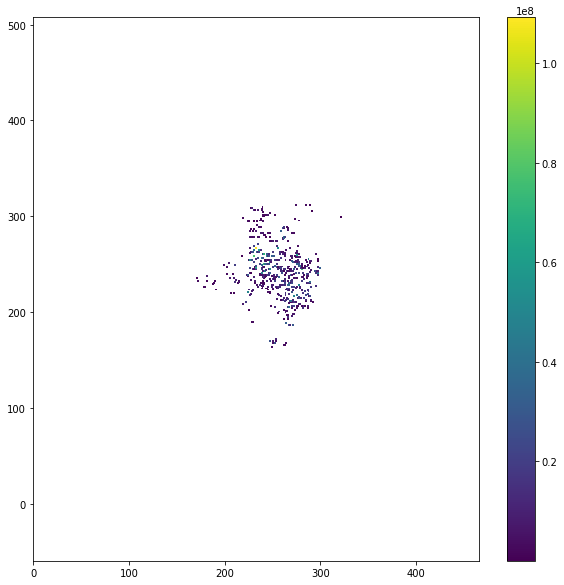

In [223]:
plt.figure(figsize=(10,10))
plt.pcolormesh(np.flipud(np.ma.masked_array(vals,vals==-9999)))
plt.axis('equal')
plt.colorbar()

(0.0, 466.0, 0.0, 448.0)

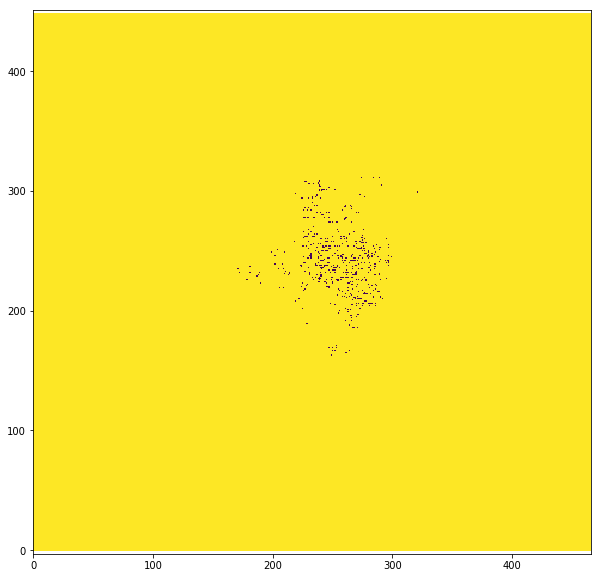

In [219]:
plt.figure(figsize=(10,10))
plt.pcolormesh(np.flipud(ds.read(1)))
plt.axis('equal')

In [129]:
ds

<open RasterReader name='../UOG/data/haines_tiffs/treatment_water_2015.tif' mode='r'>